# Proyecto 1: ONU ODS

- Juan Camilo Colmenares - 202011866
- Juan Montealegre - 20201723
- David Gonzales - 201815834

El objetivo de este proyecto es pasar 

In [196]:
import numpy as np
import pandas as pd

import re, os, string, time, unicodedata

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import word_tokenize, sent_tokenize

import inflect


from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay,
    roc_auc_score, precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline

import contractions
import seaborn as sns; sns.set()  # for plot styling


import matplotlib.pyplot as plt
import timeit

nltk.download('wordnet')
nltk.download('words')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

stop_words = stopwords.words('spanish')
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmer = nltk.stem.WordNetLemmatizer()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\juank\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\juank\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juank\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\juank\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juank\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [197]:
# pd.set_option("display.max_colwidth", None)

In [198]:
# nltk.download("punkt")
# nltk.download("stopwords")
# stopwords = stopwords.words("spanish")

In [199]:
df = pd.read_excel("data/cat_6716.xlsx")

## 1. Entendimiento de datos

In [200]:
df.shape

(3000, 2)

In [201]:
df.sample(5)

,Textos_espanol,sdg
76,"El Capítulo 3 señala que se necesita gestión para abordar las externalidades y señala que múltiples opciones de políticas pueden ayudar a abordar estos problemas, reconociendo que las respuestas específicas deberán adaptarse a las condiciones hidrogeológicas y ambientales. El Capítulo 4 proporciona una descripción general de los enfoques de gestión en los países de la OCDE que varían ampliamente, con evidencia débil de una correspondencia de restricción-respuesta. Solo cuatro de los 20 países de la OCDE que respondieron (Austria, República Checa, Eslovenia y los Países Bajos - nacionales y regionales) y cinco de las 20 regiones (la región de la isla volcánica de Jeju en Corea y las cuatro regiones españolas) informan que realizan evaluaciones periódicas de la gestión de las aguas subterráneas . Como parte de la Directiva Marco del Agua de la UE, los países miembros de la UE deben proporcionar informes sobre el estado de implementación y el estado cualitativo y cuantitativo de los organismos de gestión de aguas subterráneas.",6
1723,"Está influenciado por la demanda de la industria, el transporte y los hogares, por las políticas energéticas nacionales y por los precios de la energía nacionales e internacionales. Las principales formas renovables son la hidráulica, la geotérmica, la eólica, la biomasa, los residuos y la energía solar. En algunos países la disminución se debió a la transferencia de industrias intensivas en energía a otros países. Tal subcontratación puede aumentar las presiones sobre el medio ambiente mundial si se utilizan técnicas menos eficientes desde el punto de vista energético.",7
2176,"En el surgimiento de gobiernos democráticos en América Latina, la perspectiva neoliberal de la ley y el orden ha sido el modelo de seguridad más influyente en la región. Este enfoque se basa en la oposición entre el Estado y los agentes ilegales, como si fueran dos conjuntos diferentes de actores. Influenciado por este modelo, el presidente mexicano Vicente Fox lanzó un extenso programa contra la piratería para erradicar la venta minorista de productos falsificados. Con base en material etnográfico recolectado en el mercado de San Juan de Dios en Guadalajara, discuto sobre los intercambios entre vendedores piratas y policías. Mi argumento es que los programas de aplicación de la ley no han afectado la economía política de la corrupción, pasan por alto la red de lealtades ambiguas donde están arraigados los actores estatales e ilegales. La antropología del estado proporciona la razón fundamental para una crítica de las políticas de seguridad neoliberales.",16
985,"Por ejemplo, en Canadá, el gobierno federal no ha publicado recientemente ningún objetivo o indicador sobre el agua hacia el que puedan trabajar todos los ministerios, y la política integrada del agua se enfrenta a obstáculos. Esto puede crear tensiones entre ministerios con intereses contrapuestos a nivel subnacional y exige una personalización de la política del agua a nivel territorial. Por ejemplo, en México, los programas de la Comisión Nacional del Agua (CONAGUA) tratan de responder a la creciente demanda de agua de los distintos usuarios, especialmente de los que disponen de menos recursos hídricos.",6
2994,"E l castigo corporal se considera cada vez más como un acto de violencia contra los niños. El castigo corporal incluye cualquier uso de castigo físico contra un niño en respuesta a una mala conducta. Por lo general, esto incluye azotes, bofetadas y bofetadas, pero también incluye el uso de un objeto como una vara o un palo, tirar del cabello y torcer las orejas. Un creciente cuerpo de investigación se ha centrado en la disciplina y los efectos adversos del castigo corporal (Berlin et al., 2009, Lansford et al., 2009). La Convención de las Naciones Unidas sobre los Derechos del Niño afirma que los Estados toman “todas las medidas legislativas, administrativas, sociales y educativas apropiadas para proteger al niño de todas las form

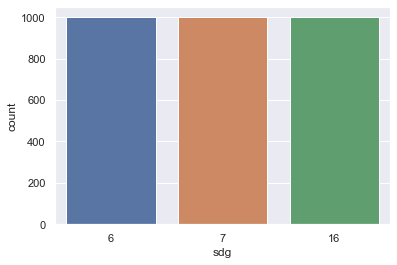

In [202]:
ax = sns.countplot(x='sdg', data=df)

In [203]:
df['document_lengths'] = np.array(list(map(len, df['Textos_espanol'].str.split(' '))))

Average number of words in Textos_espanol: 119.53733333333334.
Minimum number of words in Textos_espanol: 24.
Maximum number of words in Textos_espanol: 266.


C:\Users\juank\AppData\Local\Temp\ipykernel_17992\2379946643.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.document_lengths, bins=50, ax=ax)


<Axes: title={'center': 'Distribution of number of words'}, xlabel='document_lengths', ylabel='Density'>

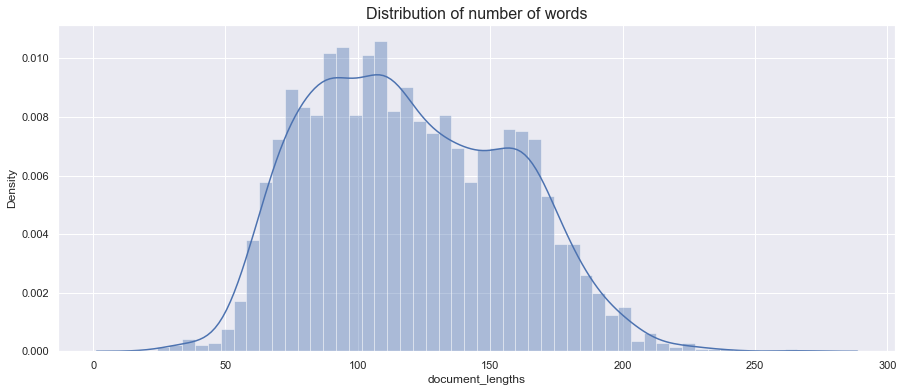

In [204]:
print("Average number of words in Textos_espanol: {}.".format(np.mean(df.document_lengths)))
print("Minimum number of words in Textos_espanol: {}.".format(min(df.document_lengths)))
print("Maximum number of words in Textos_espanol: {}.".format(max(df.document_lengths)))
## Distribution of number of words
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(df.document_lengths, bins=50, ax=ax)


In [205]:
dist_per_target= pd.pivot_table(df, values='document_lengths', index=['sdg'], aggfunc={'document_lengths': [np.mean, min, max,np.std]})
dist_per_target

,max,mean,min,std
sdg,,,,
6,239,107.351,42,34.255061
7,234,107.681,35,34.098239
16,266,143.580,24,31.996615


In [206]:
stopwords

<WordListCorpusReader in 'C:\\Users\\juank\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>

## 2. Preparación de los datos

In [219]:
 def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# def replace_numbers(words):
#     """Replace all interger occurrences in list of tokenized words with textual representation"""
#     p = inflect.engine()
#     new_words = []
#     for word in words:
#         if word.isdigit():
#                 new_word = p.number_to_words(word)
#                 new_words.append(new_word)
#         else:
#             new_words.append(word)
#     return new_words

# def get_wordnet_pos(word):
#     #Map POS tag to first character lemmatize() accepts
#     tag = nltk.pos_tag([word])[0][1][0].upper()
#     tag_dict = {"J": wordnet.ADJ,
#                 "N": wordnet.NOUN,
#                 "V": wordnet.VERB,
#                 "R": wordnet.ADV}
#     return tag_dict.get(tag, wordnet.NOUN)

# def tokenize(text):
#     text=re.sub('\\n', '. ', text)
#     text=re.sub('\s+', ' ', text)
#     text = re.sub(r' x+','', text)
#     text = re.sub(r' X+','', text)
#     text = re.sub(r'^x+ ',' ', text)
#     text = re.sub(r'^X+ ','', text)
#     result=sent_tokenize(text)
#     return result if len(result) else np.NaN

# def LemTokens(tokens):
#     tokens = [token for token in tokens if token not in stop_words] 
#     return [lemmer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

# def LemNormalize(text):
#      return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

# def normalize(sent_list):
#     return [" ".join(LemNormalize(s)) for s in sent_list]

# def remove_stopwords(words):
#     """Remove stop words from list of tokenized words"""

def preprocessing(words):
    #words = to_lowercase(words)
    #words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    #words = remove_stopwords(words)
    return words

In [220]:
df['Textos_espanol'] = df['Textos_espanol'].apply(contractions.fix) #Aplica la corrección de las contracciones 

In [221]:
df['words'] = df['Textos_espanol'].apply(word_tokenize).apply(preprocessing) #Aplica la eliminación del ruido
df.head()

,Textos_espanol,sdg,document_lengths,words
0,"Es importante destacar que, en un año de sequía, se espera que disminuyan todos los aportes, pero que aumente la demanda de agua de los cultivos y de la vegetación, lo que provocará una reducción del caudal de los ríos que están conectados hidrológicamente con el acuífero, así como una menor disponibilidad de agua para otros ecosistemas dependientes de las aguas subterráneas. Estas externalidades espaciales pueden incluir el agotamiento de los cursos de agua y el descenso del nivel freático local. Por ejemplo, el bombeo continuo del pozo B provocará el agotamiento de los cursos de agua y la reducción de su caudal.",6,103,"[Es, importante, destacar, que, en, un, ano, de, sequia, se, espera, que, disminuyan, todos, los, aportes, pero, que, aumente, la, demanda, de, agua, de, los, cultivos, y, de, la, vegetacion, lo, que, provocara, una, reduccion, del, caudal, de, los, rios, que, estan, conectados, hidrologicamente, con, el, acuifero, asi, como, una, menor, disponibilidad, de, agua, para, otros, ecosistemas, dependientes, de, las, aguas, subterraneas, Estas, externalidades, espaciales, pueden, incluir, el, agotamiento, de, los, cursos, de, agua, y, el, descenso, del, nivel, freatico, local, Por, ejemplo, el, bombeo, continuo, del, pozo, B, provocara, el, agotamiento, de, los, cursos, de, agua, y, la, reduccion, ...]"
1,"Hay una gran cantidad de literatura sobre Australia en esta área que sugiere fuertemente que el comercio de agua, especialmente en los mercados a corto plazo, no solo permite mitigar sustancialmente los impactos de las sequías en la agricultura, sino que ahora los agricultores lo consideran como un medio útil y básico. instrumento en su caja de herramientas de gestión de riesgos. Los desafíos políticos para Australia en el área de la regulación del agua en la agricultura están más en las áreas de cómo ajustar el sistema existente y los problemas de solidez relacionados con el cambio climático. Si bien el ejemplo australiano ilustra las posibles ganancias de eficiencia que surgen del comercio de agua, especialmente para gestionar la escasez de agua en circunstancias de sequía, la elección de un instrumento siempre debe considerar la gama completa de costos y beneficios.",6,142,"[Hay, una, gran, cantidad, de, literatura, sobre, Australia, en, esta, area, que, sugiere, fuertemente, que, el, comercio, de, agua, especialmente, en, los, mercados, a, corto, plazo, no, solo, permite, mitigar, sustancialmente, los, impactos, de, las, sequias, en, la, agricultura, sino, que, ahora, los, agricultores, lo, consideran, como, un, medio, util, y, basico, instrumento, en, su, caja, de, herramientas, de, gestion, de, riesgos, Los, desafios, politicos, para, Australia, en, el, area, de, la, regulacion, del, agua, en, la, agricultura, estan, mas, en, las, areas, de, como, ajustar, el, sistema, existente, y, los, problemas, de, solidez, relacionados, con, el, cambio, climatico, Si, ...]"
2,"Los procesos de descentralización, emprendidos para una serie de actividades que antes realizaba el gobierno central, llevaron a modificaciones importantes en la forma en que se administraba y operaba el sector del agua. Las únicas excepciones a esta tendencia fueron Azerbaiyán, Bielorrusia y Turkmenistán, donde la gestión del sector del agua ha permanecido fuertemente centralizada. En Azerbaiyán, por ejemplo, la empresa nacional AZERSU JSC suministra agua al 65 % de la población, con un 10 % proporcionado por pequeños operadores privados y un 25 % por los propios hogares.",6,89,"[Los, procesos, de, descentralizacion, emprendidos, para, una, serie, de, actividades, que, antes, realizaba, el, gobierno, central, llevaron, a, modificaciones, importantes, en, la, forma, en, que, se, administraba, y, operaba, el, sector, del, agua, Las, unicas, excepciones, a, esta, tendencia, fueron, Azerbaiyan, Bielorrusia, y, Turkmenistan, donde, la, gestion, del, sector, del, agua, ha, permanecido, fuertemente, central

In [231]:
df['words'] = df['words'].apply(lambda x: ' '.join(map(str, x)))
df

,Textos_espanol,sdg,document_lengths,words
0,"Es importante destacar que, en un año de sequía, se espera que disminuyan todos los aportes, pero que aumente la demanda de agua de los cultivos y de la vegetación, lo que provocará una reducción del caudal de los ríos que están conectados hidrológicamente con el acuífero, así como una menor disponibilidad de agua para otros ecosistemas dependientes de las aguas subterráneas. Estas externalidades espaciales pueden incluir el agotamiento de los cursos de agua y el descenso del nivel freático local. Por ejemplo, el bombeo continuo del pozo B provocará el agotamiento de los cursos de agua y la reducción de su caudal.",6,103,Es importante destacar que en un ano de sequia se espera que disminuyan todos los aportes pero que aumente la demanda de agua de los cultivos y de la vegetacion lo que provocara una reduccion del caudal de los rios que estan conectados hidrologicamente con el acuifero asi como una menor disponibilidad de agua para otros ecosistemas dependientes de las aguas subterraneas Estas externalidades espaciales pueden incluir el agotamiento de los cursos de agua y el descenso del nivel freatico local Por ejemplo el bombeo continuo del pozo B provocara el agotamiento de los cursos de agua y la reduccion de su caudal
1,"Hay una gran cantidad de literatura sobre Australia en esta área que sugiere fuertemente que el comercio de agua, especialmente en los mercados a corto plazo, no solo permite mitigar sustancialmente los impactos de las sequías en la agricultura, sino que ahora los agricultores lo consideran como un medio útil y básico. instrumento en su caja de herramientas de gestión de riesgos. Los desafíos políticos para Australia en el área de la regulación del agua en la agricultura están más en las áreas de cómo ajustar el sistema existente y los problemas de solidez relacionados con el cambio climático. Si bien el ejemplo australiano ilustra las posibles ganancias de eficiencia que surgen del comercio de agua, especialmente para gestionar la escasez de agua en circunstancias de sequía, la elección de un instrumento siempre debe considerar la gama completa de costos y beneficios.",6,142,Hay una gran cantidad de literatura sobre Australia en esta area que sugiere fuertemente que el comercio de agua especialmente en los mercados a corto plazo no solo permite mitigar sustancialmente los impactos de las sequias en la agricultura sino que ahora los agricultores lo consideran como un medio util y basico instrumento en su caja de herramientas de gestion de riesgos Los desafios politicos para Australia en el area de la regulacion del agua en la agricultura estan mas en las areas de como ajustar el sistema existente y los problemas de solidez relacionados con el cambio climatico Si bien el ejemplo australiano ilustra las posibles ganancias de eficiencia que surgen del comercio de agua especialmente para gestionar la escasez de agua en circunstancias de sequia la eleccion de un instrumento siempre debe considerar la gama completa de costos y beneficios
2,"Los procesos de descentralización, emprendidos para una serie de actividades que antes realizaba el gobierno central, llevaron a modificaciones importantes en la forma en que se administraba y operaba el sector del agua. Las únicas excepciones a esta tendencia fueron Azerbaiyán, Bielorrusia y Turkmenistán, donde la gestión del sector del agua ha permanecido fuertemente centralizada. En Azerbaiyán, por ejemplo, la empresa nacional AZERSU JSC suministra agua al 65 % de la población, con un 10 % proporcionado por pequeños operadores privados y un 25 % por los propios hogares.",6,89,Los procesos de descentralizacion emprendidos para una serie de actividades que antes realizaba el gobierno central llevaron a modificaciones importantes en la forma en que se administraba y operaba el sector del agua Las unicas excepciones a esta tendencia fueron Azerbaiyan Bielorrusia y Turkmenistan donde la gestion del sector del agua ha permanecido fue

In [232]:
X_train, X_test, y_train, y_test = train_test_split(df[["words"]], df["sdg"], test_size=0.3, stratify=df["sdg"], random_state=1)

In [233]:
X_train.shape, X_test.shape

((2100, 1), (900, 1))

In [234]:
bow = CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [235]:
X_bow = bow.fit_transform(X_train["words"])

c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [236]:
print("Vocabulary size:", len(bow.vocabulary_))

Vocabulary size: 17834


## Training a model with BoW

In [237]:
bow_model = RandomForestClassifier(random_state=2)

In [238]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=2)

<Axes: >

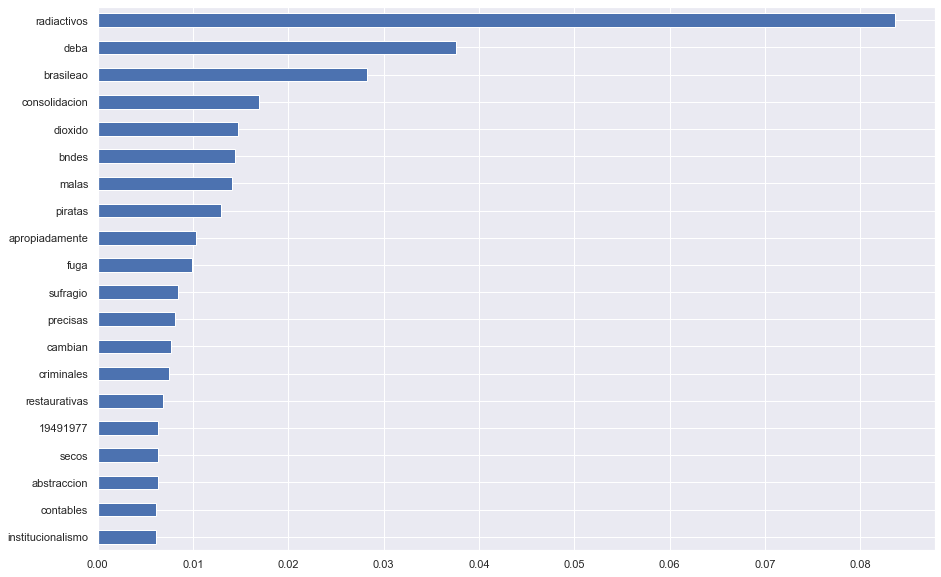

In [239]:
pd.Series(bow_model.feature_importances_, index=bow.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [240]:
bow_estimators = bow_model.estimators_
print("Number of trees:", len(bow_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 100.74


In [241]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test["text5"]))

KeyError: 'text5'

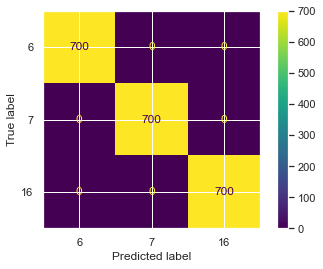

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

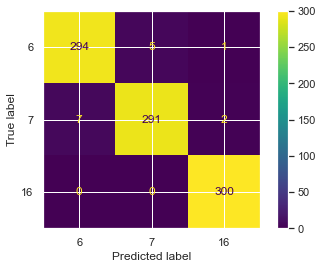

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [242]:
print("Precision Score : ",precision_score(y_test, y_test_bow_predict, 
                                           pos_label='positive',
                                           average='micro'))
print("Recall Score : ",recall_score(y_test, y_test_bow_predict, 
                                           pos_label='positive',
                                           average='micro'))

Precision Score :  0.9833333333333333
Recall Score :  0.9833333333333333


c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
